Mounting Google Drive

In [1]:
!pip install torchsummary

In [2]:
!pip install --quiet torch_lr_finder


In [3]:
# !rm -r era_support_packages/

In [4]:
!git clone https://github.com/sushant097/era_support_packages.git

Cloning into 'era_support_packages'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 34 (delta 14), reused 29 (delta 9), pack-reused 0
Receiving objects: 100% (34/34), 9.25 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (14/14), done.


Importing libraries

In [5]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR
import cv2
from era_support_packages.utils import (
   test, train, plot_losses, plot_incorrect_prediction

)

from era_support_packages.custom_resnet import resnet_custom
from era_support_packages.resnet import ResNet18
from era_support_packages.utils import *
from torchsummary import summary


from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Updating Device to CUDA

In [6]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Defining data tranformations

In [7]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout (max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=.45, mask_fill_value = None),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=15, p=0.4),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
test_transforms = A.Compose(
    [
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
    ]
)

Custom Dataset that support albumentation library

In [8]:
class Cifar10DS(datasets.CIFAR10):
    def __init__(self, root="./data", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label


Downloading MNIST dataset and splitting to train and test set

In [9]:
train_data = Cifar10DS('../data', train=True, download=True, transform=train_transforms)
test_data = Cifar10DS('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 93812889.60it/s] 


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [10]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Creating Data Loaders from train data and test data

In [11]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

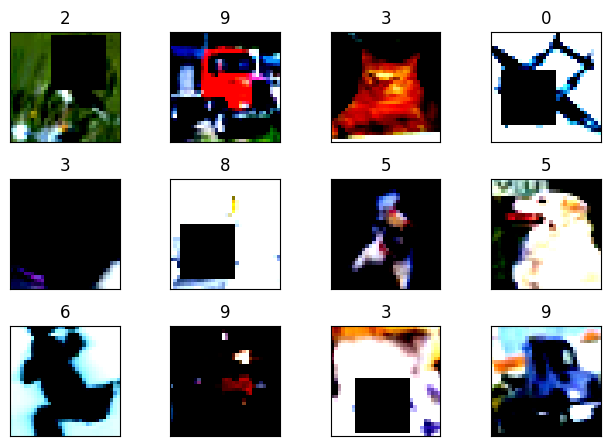

In [12]:
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i], (1, 2, 0)), cmap='gray')
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])
plt.show()

Transferring model to GPU and printing model summary

In [13]:
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.65E-03


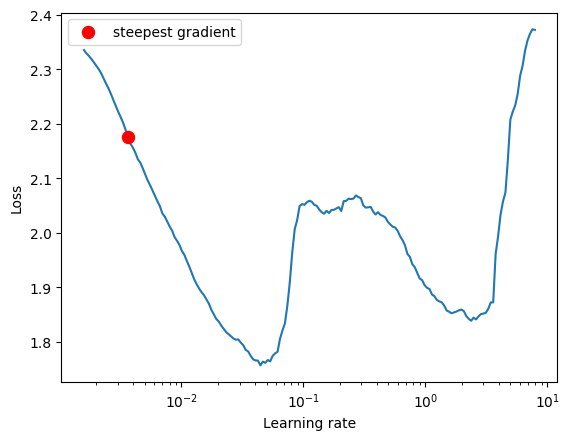

In [14]:
from torch_lr_finder import LRFinder

model = ResNet18().to(device)
#optimizer_lr = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [15]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.04448782831127586


In [16]:
optimizer = optim.SGD(model.parameters(), lr=8.22E-04, weight_decay=1e-4)
EPOCHS = 25

In [17]:
scheduler = OneCycleLR(
        optimizer,
        max_lr= ler_rate,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=10,
        anneal_strategy='linear'
    )

In [18]:

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, criterion, epoch)
    test(model, device, test_loader, criterion)

EPOCH: 0


Train: Loss=1.5297 Batch_id=97 Accuracy=34.09: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0029, Accuracy: 4744/10000 (47.44%)

EPOCH: 1


Train: Loss=1.3182 Batch_id=97 Accuracy=51.30: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0025, Accuracy: 5478/10000 (54.78%)

EPOCH: 2


Train: Loss=1.1069 Batch_id=97 Accuracy=59.03: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0019, Accuracy: 6708/10000 (67.08%)

EPOCH: 3


Train: Loss=0.8687 Batch_id=97 Accuracy=65.14: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0017, Accuracy: 7017/10000 (70.17%)

EPOCH: 4


Train: Loss=0.7928 Batch_id=97 Accuracy=69.56: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0015, Accuracy: 7293/10000 (72.93%)

EPOCH: 5


Train: Loss=0.8676 Batch_id=97 Accuracy=72.36: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0015, Accuracy: 7480/10000 (74.80%)

EPOCH: 6


Train: Loss=0.8390 Batch_id=97 Accuracy=74.51: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0016, Accuracy: 7439/10000 (74.39%)

EPOCH: 7


Train: Loss=0.6530 Batch_id=97 Accuracy=76.59: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0014, Accuracy: 7547/10000 (75.47%)

EPOCH: 8


Train: Loss=0.6389 Batch_id=97 Accuracy=78.38: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 7957/10000 (79.57%)

EPOCH: 9


Train: Loss=0.5989 Batch_id=97 Accuracy=79.75: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0013, Accuracy: 7986/10000 (79.86%)

EPOCH: 10


Train: Loss=0.5646 Batch_id=97 Accuracy=81.16: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0011, Accuracy: 8129/10000 (81.29%)

EPOCH: 11


Train: Loss=0.5207 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8237/10000 (82.37%)

EPOCH: 12


Train: Loss=0.5004 Batch_id=97 Accuracy=82.94: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0011, Accuracy: 8186/10000 (81.86%)

EPOCH: 13


Train: Loss=0.4612 Batch_id=97 Accuracy=84.13: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0013, Accuracy: 8002/10000 (80.02%)

EPOCH: 14


Train: Loss=0.3673 Batch_id=97 Accuracy=84.88: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0010, Accuracy: 8324/10000 (83.24%)

EPOCH: 15


Train: Loss=0.4433 Batch_id=97 Accuracy=85.78: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0012, Accuracy: 8081/10000 (80.81%)

EPOCH: 16


Train: Loss=0.3329 Batch_id=97 Accuracy=86.27: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0010, Accuracy: 8367/10000 (83.67%)

EPOCH: 17


Train: Loss=0.4047 Batch_id=97 Accuracy=87.36: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0010, Accuracy: 8450/10000 (84.50%)

EPOCH: 18


Train: Loss=0.3238 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0012, Accuracy: 8286/10000 (82.86%)

EPOCH: 19


Train: Loss=0.3359 Batch_id=97 Accuracy=88.16: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0010, Accuracy: 8485/10000 (84.85%)

EPOCH: 20


Train: Loss=0.3261 Batch_id=97 Accuracy=88.42: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0009, Accuracy: 8516/10000 (85.16%)

EPOCH: 21


Train: Loss=0.2753 Batch_id=97 Accuracy=88.97: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0010, Accuracy: 8472/10000 (84.72%)

EPOCH: 22


Train: Loss=0.3070 Batch_id=97 Accuracy=89.35: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]


Test set: Average loss: 0.0011, Accuracy: 8373/10000 (83.73%)

EPOCH: 23


Train: Loss=0.2805 Batch_id=97 Accuracy=89.89: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0009, Accuracy: 8578/10000 (85.78%)

EPOCH: 24


Train: Loss=0.3332 Batch_id=97 Accuracy=89.95: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0009, Accuracy: 8616/10000 (86.16%)



## Plot Losses

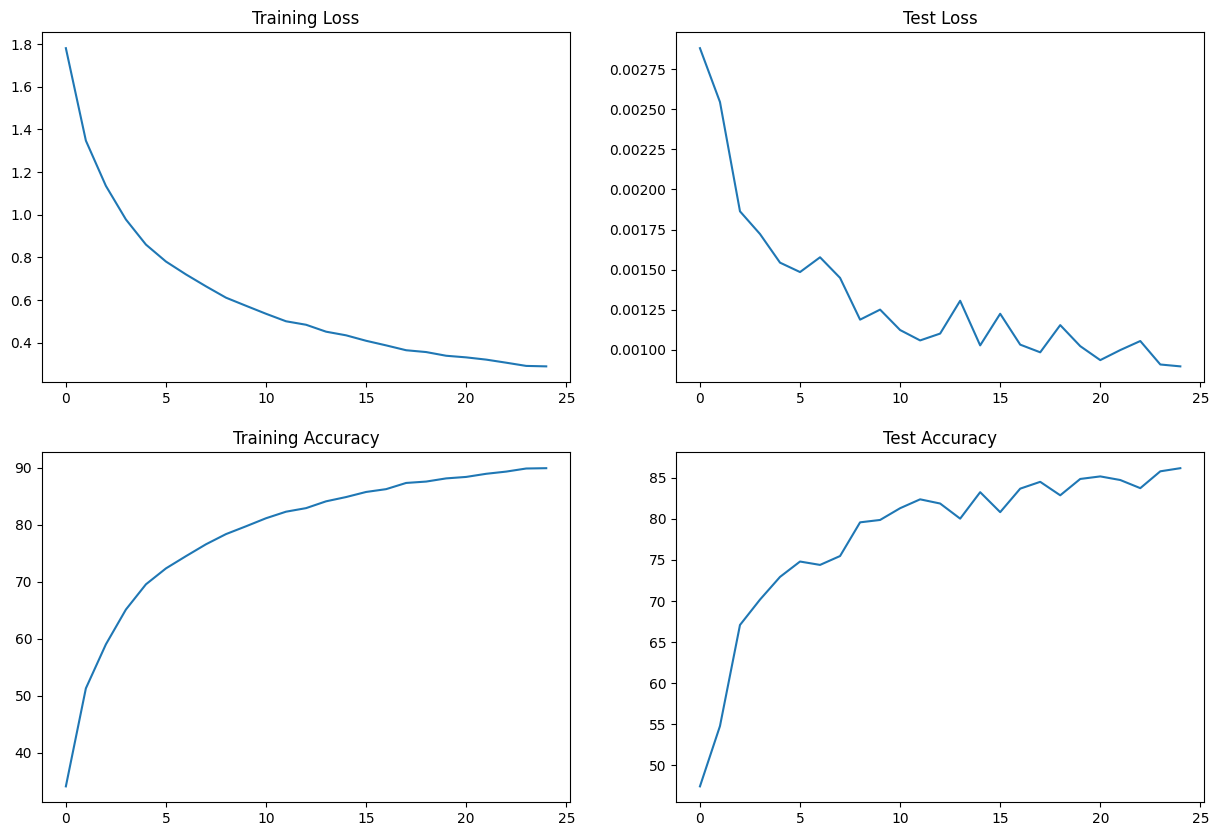

In [19]:
plot_losses()

### Mispredicted images

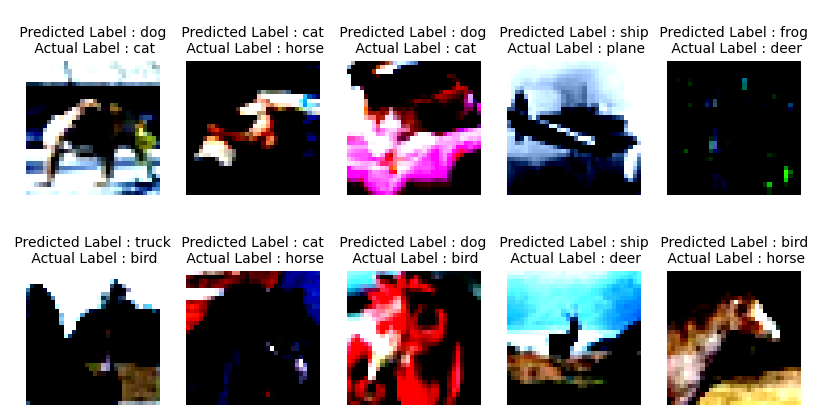

In [20]:
wrong_prediction_list = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the maximum probabilities
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))
plot_incorrect_prediction(wrong_prediction_list, n=10 )

### GradCAM

In [21]:
target_layers = ["layer1","layer2","layer3","layer4"] # channel size 8X8
torch.autograd.set_detect_anomaly(True)
image_size = (3,32,32)

In [22]:
gcam_layers, probs, pred_class= generate_gradcam(wrong_prediction_list[:10], model, target_layers,device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


100%|██████████| 170498071/170498071 [00:01<00:00, 95861048.97it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


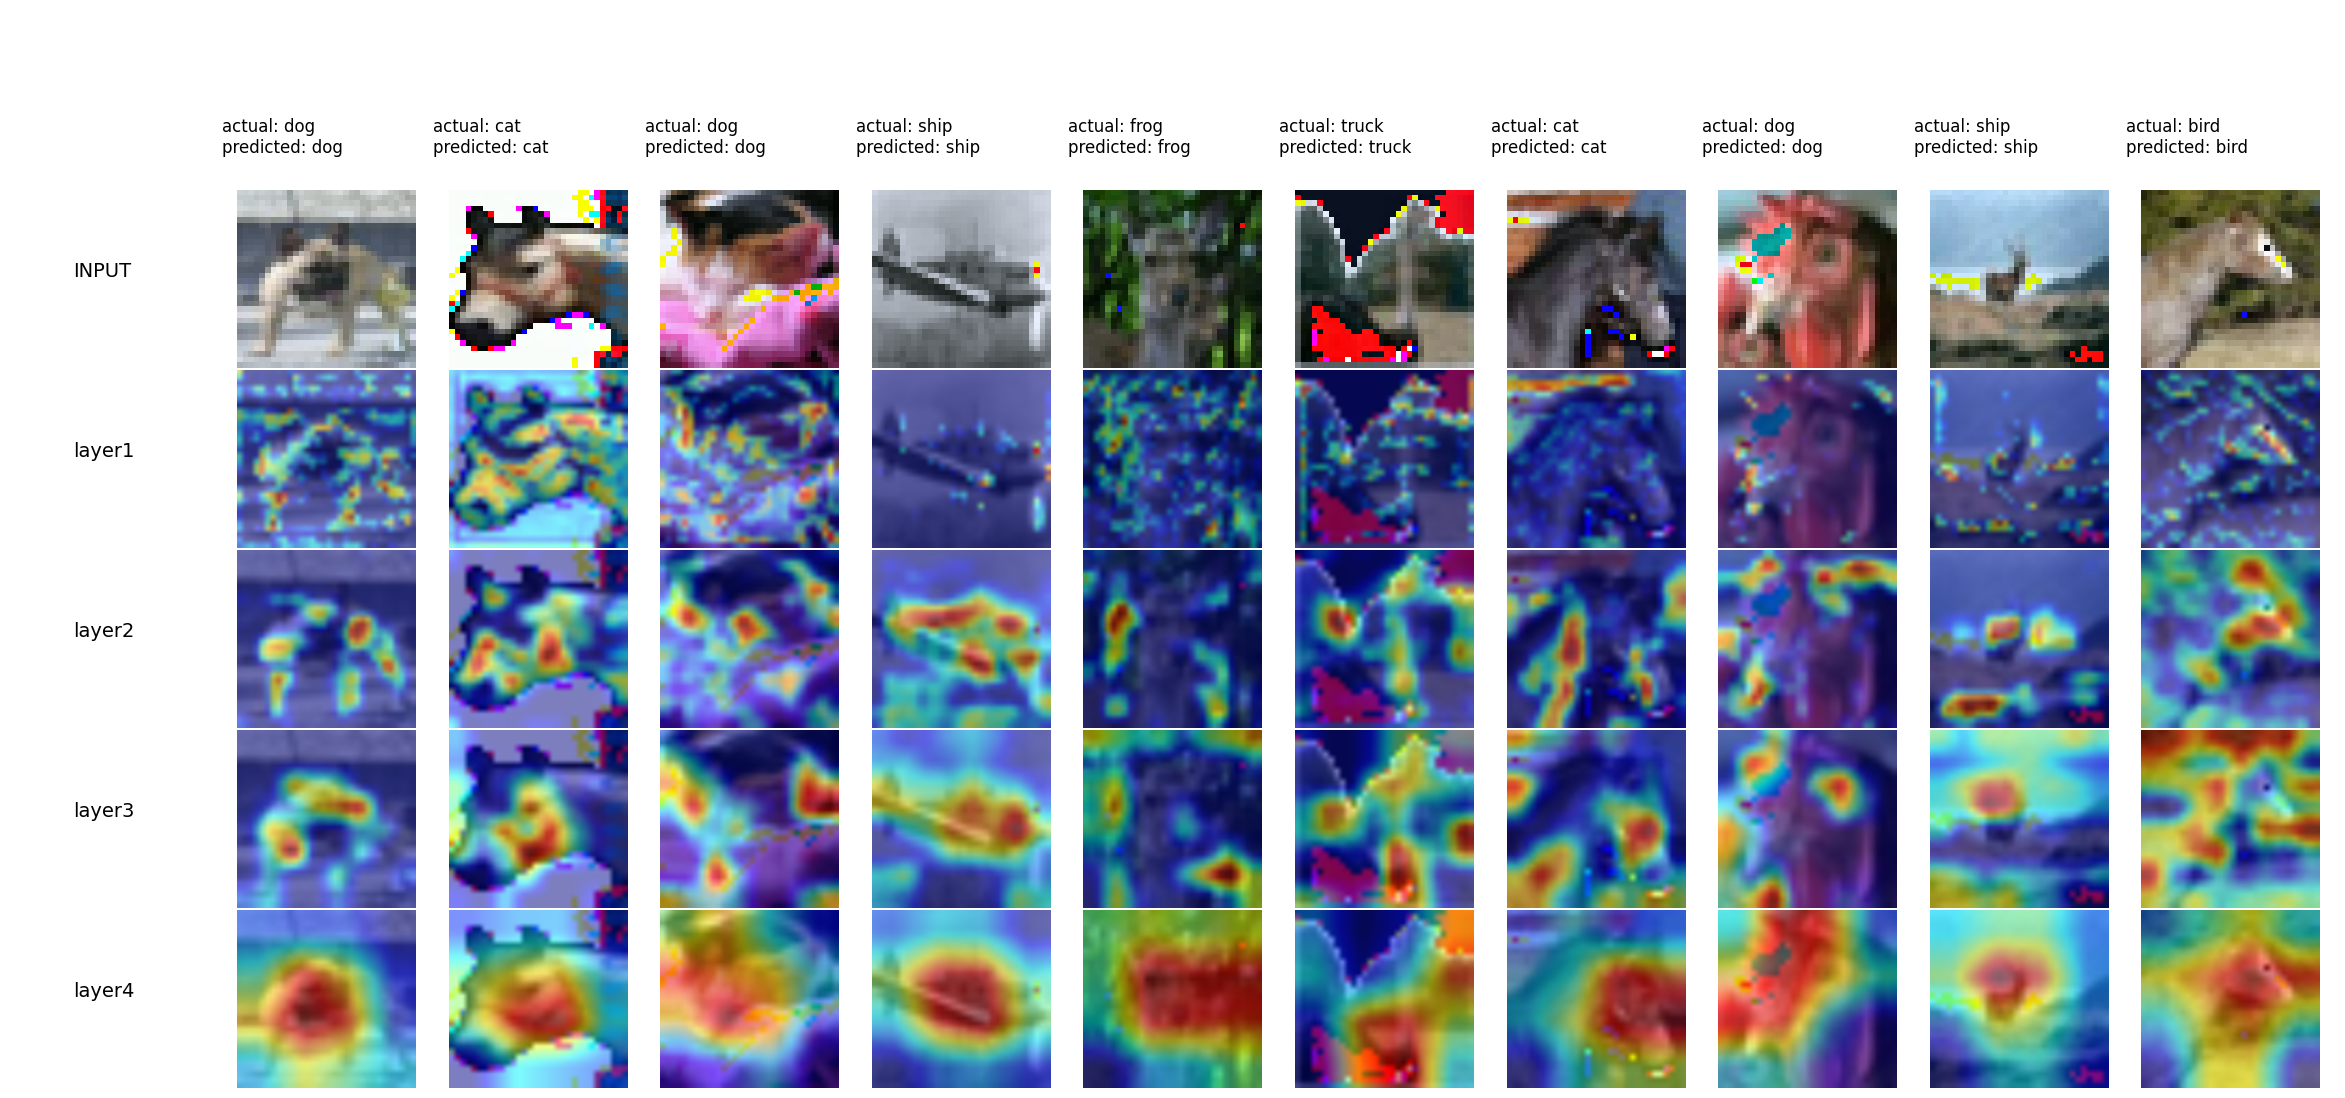

In [23]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_gradcam(gcam_layers, target_layers, classes, image_size ,pred_class, wrong_prediction_list[:10])